In [4]:
#@title Run this to download data and prepare the environment!  { display-mode: "form" }

import cv2
import dlib
import pickle
import warnings
import numpy as np
import pandas as pd
import seaborn as sns

import urllib.request

from sklearn import metrics
from scipy.spatial import distance
from sklearn.metrics import accuracy_score
from matplotlib import pyplot as plt
from tqdm import tqdm,tqdm_pandas
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import re
import gdown
import keras

from keras.models import Sequential
from keras.utils import to_categorical
from keras.optimizers import adam
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.losses import categorical_crossentropy
from keras.optimizers import Adam, SGD
from keras.regularizers import l2
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import load_model

# grab tools from our tensorflow and keras toolboxes!
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Activation, Dropout, Flatten, Dense
from keras import optimizers

warnings.filterwarnings("ignore")
def model_to_string(model):
    import re
    stringlist = []
    model.summary(print_fn=lambda x: stringlist.append(x))
    sms = "\n".join(stringlist)
    sms = re.sub('_\d\d\d','', sms)
    sms = re.sub('_\d\d','', sms)
    sms = re.sub('_\d','', sms)  
    return sms

###Getting the csv data loaded

dataset_url = 'https://drive.google.com/uc?id=1xFiYsULlQWWmi2Ai0fHjtApniP5Pscuf'
dataset_path = './ferdata.csv'
gdown.download(dataset_url, dataset_path, True)

###Getting the Dlib Shape predictor!

dlibshape_url = 'https://drive.google.com/uc?id=17D3D89Gke6i5nKOvmsbPslrGg5rVgOwg'
dlibshape_path ='./shape_predictor_68_face_landmarks.dat'
gdown.download(dlibshape_url, dlibshape_path, True)

###Getting the Xpure loaded

pureX_url = 'https://drive.google.com/uc?id=1CglpXodenZVrkaZehLtfykfQv8dcnfO9'
pureX_path = './pureX.npy'
gdown.download(pureX_url, pureX_path,True)

###Getting the Xdata loaded

dataX_url = 'https://drive.google.com/uc?id=1sIJGxUM6rNBcWxucs6iynDepeKU1Q56p'
dataX_path = './dataX.npy'
gdown.download(dataX_url, dataX_path, True)


###Getting the Ydata loaded

dataY_url = 'https://drive.google.com/uc?id=1Rfr0OP-hZO_UZfuOyMNR2RjNRAro85zE'
dataY_path = './dataY.npy'
gdown.download(dataY_url, dataY_path, True)


print ("Data Downloaded!")


'''
Plots the confusion Matrix and saves it
'''
def plot_confusion_matrix(y_true,y_predicted):
  cm = metrics.confusion_matrix(y_true, y_predicted)
  print ("Plotting the Confusion Matrix")
  labels = list(label_map.values())
  df_cm = pd.DataFrame(cm,index = labels,columns = labels)
  fig = plt.figure()
  res = sns.heatmap(df_cm, annot=True,cmap='Blues', fmt='g')
  plt.yticks([0.5,1.5,2.5,3.5,4.5], labels,va='center')
  plt.title('Confusion Matrix - TestData')
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
 
  plt.show()
  plt.close()

def plot_graphs(history, best):
  
  plt.figure(figsize=[10,4])
  # summarize history for accuracy
  plt.subplot(121)
  plt.plot(history.history['acc'])
  plt.plot(history.history['val_acc'])
  plt.title('model accuracy across training\n best accuracy of %.02f'%best[1])
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  
  # summarize history for loss
  plt.subplot(122)
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss across training\n best loss of %.02f'%best[0])
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()

#Integer to Label Mapping
label_map = {"0":"ANGRY","1":"HAPPY","2":"SAD","3":"SURPRISE","4":"NEUTRAL"}


#Load the 68 face Landmark file
predictor = dlib.shape_predictor('./shape_predictor_68_face_landmarks.dat')
"""
Returns facial landmarks for the given input image path
"""
def get_landmarks(image):
  
  
  #:type image : cv2 object
  #:rtype landmarks : list of tuples where each tuple represents 
  #                  the x and y co-ordinates of facial keypoints
  
  #Bounding Box co-ordinates around the face(Training data is 48*48(cropped faces))
  rects = [dlib.rectangle(left=1, top=1, right=47, bottom=47)]

  #Read Image using OpenCV
  #image = cv2.imread(image_path)
  #Detect the Faces within the image
  landmarks = [(p.x, p.y) for p in predictor(image, rects[0]).parts()]
  return image,landmarks

"""
Display image with its Facial Landmarks
"""
def image_landmarks(image,face_landmarks):
  """
  :type image_path : str
  :type face_landmarks : list of tuples where each tuple represents 
                     the x and y co-ordinates of facial keypoints
  :rtype : None
  """
  radius = -4
  circle_thickness = 1
  image_copy = image.copy()
  for (x, y) in face_landmarks:
    cv2.circle(image_copy, (x, y), circle_thickness, (255,0,0), radius)
    
  plt.imshow(image_copy, interpolation='nearest')
  plt.show()
  
"""
Computes euclidean distance between 68 Landmark Points for our features
e_dist is a list of features that will go into our model.
Each feature is a distance between two landmark points, and every pair of points
must have a feature.
"""
  
def landmarks_edist(face_landmarks):
    e_dist = []
    for i in range(len(face_landmarks)):
        for j in range(len(face_landmarks)):
            if i!= j:
                e_dist.append(distance.euclidean(face_landmarks[i],face_landmarks[j]))
    return e_dist
  
def compare_learning(mlp, lm, cnn, vgg): # there's one model missing: MLP from pixels
  
  # summarize history for accuracy
  plt.plot(vgg.history['val_acc'],)
  plt.plot(cnn.history['val_acc'])
  plt.plot(mlp.history['val_acc'],)
  plt.plot(lm.history['val_acc'])
  plt.ylabel('validitation accuracy')
  plt.xlabel('epoch')
  plt.legend(['cnn_transfer', 'cnn_scratch', 'mlp_pixels', 'mlp_landmarks'], bbox_to_anchor=[1,1])
  plt.xticks(range(0, epochs+1, 5), range(0, epochs+1, 5))
  plt.show()


Data Downloaded!


#Understanding and building Neural Networks

A neural network is a series of algorithms that endeavors to recognize underlying relationships in a set of data through a process that mimics the way the human brain operates. Basically, neural network algorithm helps computers think and learn like humans.

The whole idea of artificial neural network is based on the concept of the structure and functions of a human brain. A human brain consists of neurons that process and transmit information between themselves.

### Why try neural networks?

Our Baseline model performed at ~50 %

Human accuracy for fer2013 is around 65 %, suggesting that we could do better!

What we require now is a model that can capture more complicated patterns. One class of models that is able to do this and has been very effective for doing this for images are neural networks. 


### What are neural networks?


## Building networks

To build neural networks in Python, we use the packages known as `tensorflow` and `keras`. Let's learn how to build and use these networks!

Tensorflow calls the various machine learning algorithms that it uses 'models'.  These 'models' are 'learning machines.''

1. We **teach** models by **training** them on **data**. 
2. We **use** models to **predict** things. 

Here is example code for building a Tensorflow model with Keras:

The things you'll want to pay most attention to as we go over how to build networks are: 
1. The number of neurons
2. The activation of the neurons
3. The losses and metrics

Everything else will work with the default settings!

Let's walk though what each of these lines of code means!

**1. Specify model**

```
model = Sequential()
```
In this line of code, we build our network where the information flows from LEFT to RIGHT through the network in ONE DIRECTION as opposed to multiple directions. Neurons on the right never pass informations to neurons on the left of it. 


**2. Add layers to the network**
```
model.add(Dense(4,input_shape = (3,), activation = 'sigmoid'))
```
In this code, we `add` a `layer` of neurons to our network. 

This layers consists of 4 neurons. Each neuron is DENSE and connects to all of the previous layer's inputs and all of the subsequent layers outputs. We specify that there are 3 inputs here.

We also specify what kind of output the neuron will give. If you want the neuron to output a number between 0 and 1 (like a probability!) you would use 'softmax' or 'sigmoid'. If you want the neuron to output any number, you can use 'linear'! You'll also often see 'relu', which is when a neuron will only output positive numbers. 

```
model.add(Dense(1, activation = 'softmax'))
```
This code adds ANOTHER layer to the network that has 1 neuron. This one neuron is used to predict a continuous value!

**3. Turn the model on by compiling it** 

After having built the network, we want to train and use it, so we have to 'turn it on' and 'compile' it. To turn it on, we have to specify at the very least, a loss, an optimizer, and some ways of evaluating the model (metrics). Don't worry too much about what this means! Just know that this is necessary. 

```
model.compile(loss='mean_squared_error',
               optimizer = 'adam',
               metrics = ['mean_squared_error'])
  ```
  
  Once we've created our network, we can use it very simply! Just like we did with sklearn, we define our input data (x), the true predictions from that data (y), and then train our model with `fit`. 

```
model.fit(x, y)
```

To use the model, you can use it to predict something with:
```
y = model.predict_classes(x)
```



##Coding a 2 hidden layer MLP

Just as we went over last week, neural networks look something like this: 

![A 2 layer neural network](https://cdn-images-1.medium.com/max/1600/1*DW0Ccmj1hZ0OvSXi7Kz5MQ.jpeg)

Each orange and blue node is a neuron. The network itself is composed of a bunch of neurons that talk to each other and eventually give us a prediction. Let's get a bit more concrete with this...

### How can we build this network above? Fill in the ___ 's below 

In [6]:
# First, we initialize our model
tmp_model = Sequential()
# then we add a "Dense" (i.e. fully connected) layer
tmp_model.add(Dense(7, input_shape=(5,), activation = 'relu')) # for the first layer we specify the input dimensions 
# then we have to add another layer 
tmp_model.add(Dense(7, activation = 'relu'))
# we end by defining the output layer, which has the number of dimensions of the predictions we're making
tmp_model.add(Dense(4, activation = 'linear'))
# we finalize the model by "compiling" it and defining some other hyperparameters 
tmp_model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_error'])
print("model initialized")

model initialized


## Building our custom neural network

###Keypoints

We will build a simple 3-layer network for our first model!


For our model, we have as our layers: 
* Input Layer:  However many inputs there are!
* Layer 1 (Hidden): 1024 neurons that are activated by `'relu'` and weights are intialized using `kernel_initializer='glorot_normal'`. Specify the input shape as `(4556,)`.
* Layer 2 (Hidden): 512 neurons that are activated by `'relu'` and weights are intialized using `kernel_initializer='glorot_normal'`
* Layer 3 (Output): 5 neuron that should have an appropriate activation. 
* We will compile with the `optimizers.SGD(lr=0.001)` optimizer

As a hint for the output activation and the compilation loss, we know that:
* Multi-class classification problems require an output activation of `'softmax'` and a loss of `'categorical_crossentropy'`




###Build your Model

In [55]:
perceptron = Sequential()
perceptron.add(Dense(units = 1024, input_shape = (4556,),kernel_initializer='glorot_normal',activation = 'relu'))
perceptron.add(Dense(units = 512,kernel_initializer='glorot_normal' , activation = 'relu'))
perceptron.add(Dense(units = 5, activation = 'softmax'))
perceptron.compile(loss='categorical_crossentropy', optimizer=SGD(lr=0.001), metrics=['acc'])

###Keras Neural Network Model Hyperparameters

Neural Network performance depends a lot on *how much* they train. As we'll see, they usually get better with more training BUT actually can get worse with too much training. With too much training, our model can get overconfident in its abilities with the training manual (overfitting), and so doesn't actually think (generalize) when it is tested. 

The  `fit()` function pertain to how the neural networks train. Don't worry too much about the extra options, what really matters for us is that the right data is specified.


What are all these options?
* `epochs`: how many times the model trains on the entire data set
* `batch_size`: number of samples processed at a time
* `shuffle`: mixes the training dataset so the model pays better attention to the data and learns better while training
* `validation_data`: we request that our model tests itself on the `test_data` after every epoch. **It is essential to use validation data to test for overfitting!**
* `callbacks`: With a custom command, we tell our model to save the best version of itself to a model file called `best_dnn_model.h5`. 


### Set Hyper parameters that will be used across all models

In [56]:
# the number of times we pass all the training data through the model 
epochs = 20
# the number of examples we pass to the model at each time
batch_size = 64
# the proportion of testing data we set aside (e.g. 10%)
test_ratio = .1
# the number of emotion categories we have to predict
n_labels = 5

### load all data

In [57]:
########### PIXEL DATA
# load the raw pixel values (in vector form)
dataX_pixels = np.load('pureX.npy')
dataY = np.load('dataY.npy')

# convert labels to one hot encoding
y_onehot = keras.utils.to_categorical(dataY, len(set(dataY)))

# split Data into Train, Test (90-10)
X_train, X_test, y_train, y_test = train_test_split(dataX_pixels, y_onehot, test_size=test_ratio, random_state=42)

#### standardize the data ##########
pixel_scaler = StandardScaler()
pixel_scaler.fit(X_train)
X_train = pixel_scaler.transform(X_train)
X_test = pixel_scaler.transform(X_test)

In [58]:
########## LANDMARK DATA
# load landmark (lm) data
dataX_lm = np.load('./dataX.npy')
# we don't need dataY for this--it's the same as for the pixle-level data

# split Data into Train, Test (90-10)
X_train_lm, X_test_lm, y_train_lm, y_test_lm = train_test_split(dataX_lm, y_onehot, test_size=0.1, random_state=42)

#### Standardize the data ##########
lm_scaler = StandardScaler()
lm_scaler.fit(X_train_lm)
X_train_lm = lm_scaler.transform(X_train_lm)
X_test_lm = lm_scaler.transform(X_test_lm)

#Applying Neural Networks (MLPs) to predicting emotions

### Loading and formatting data for all models in notebook 

## Exercise: Build a simple MLP for emotion detection

In [59]:
mlp_model = Sequential()
mlp_model.add(Dense(5120, activation='relu',kernel_initializer='glorot_normal', input_shape=( X_train.shape[1]   ,)))
mlp_model.add(Dropout(0.5))
mlp_model.add(Dense(512,kernel_initializer='glorot_normal', activation='relu'))
mlp_model.add(Dropout(0.5))
mlp_model.add(Dense(256,kernel_initializer='glorot_normal', activation='relu'))
mlp_model.add(Dropout(0.5))
mlp_model.add(Dense(n_labels, activation='softmax'))


In [60]:
X_train.shape[1]

2304

In [61]:
mlp_model.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_37 (Dense)             (None, 5120)              11801600  
_________________________________________________________________
dropout_19 (Dropout)         (None, 5120)              0         
_________________________________________________________________
dense_38 (Dense)             (None, 512)               2621952   
_________________________________________________________________
dropout_20 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_39 (Dense)             (None, 256)               131328    
_________________________________________________________________
dropout_21 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_40 (Dense)             (None, 5)               

In [62]:
# Compiling the model with SGD optimixer and categorical crossentropy loss
mlp_model.compile(loss=categorical_crossentropy, optimizer=SGD(lr=0.001), metrics=['acc'])
              
#Saves the Best Model Based on Val Loss
checkpoint = ModelCheckpoint('best_mlp_model.h5', verbose=1, monitor='val_acc', save_best_only=True,  mode='auto')  

In [63]:
#training the model
mlp_history = mlp_model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, 
                            callbacks=[checkpoint], validation_data=(X_test, y_test), shuffle=True)

Train on 18000 samples, validate on 2000 samples
Epoch 1/20
18000/18000 [==============================] - 2s 87us/step - loss: 2.0744 - acc: 0.2246 - val_loss: 1.5625 - val_acc: 0.2770

Epoch 00001: val_acc improved from -inf to 0.27700, saving model to best_mlp_model.h5
Epoch 2/20
18000/18000 [==============================] - 1s 83us/step - loss: 1.8157 - acc: 0.2455 - val_loss: 1.5442 - val_acc: 0.3005

Epoch 00002: val_acc improved from 0.27700 to 0.30050, saving model to best_mlp_model.h5
Epoch 3/20
18000/18000 [==============================] - 1s 83us/step - loss: 1.7256 - acc: 0.2596 - val_loss: 1.5435 - val_acc: 0.3125

Epoch 00003: val_acc improved from 0.30050 to 0.31250, saving model to best_mlp_model.h5
Epoch 4/20
18000/18000 [==============================] - 1s 82us/step - loss: 1.6708 - acc: 0.2641 - val_loss: 1.5397 - val_acc: 0.3185

Epoch 00004: val_acc improved from 0.31250 to 0.31850, saving model to best_mlp_model.h5
Epoch 5/20
18000/18000 [======================

##Neural Network Model Evaluation on pixel inputs

###Evaluate best model

In [64]:
mlp_performance = mlp_model.evaluate(X_test, y_test, batch_size=64)

2000/2000 [==============================] - 0s 51us/step


###Visualize accuracy and loss over training + display best model's performance

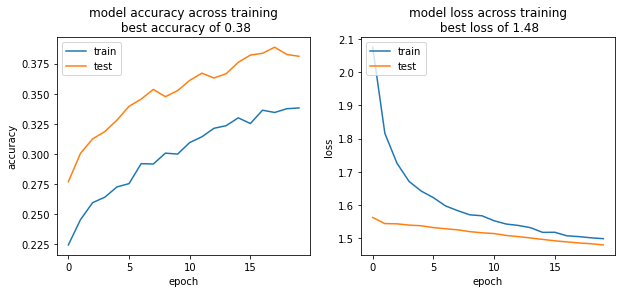

In [65]:
plot_graphs(mlp_history, mlp_performance); 

###Plot the Confusion Matrix

Plotting the Confusion Matrix


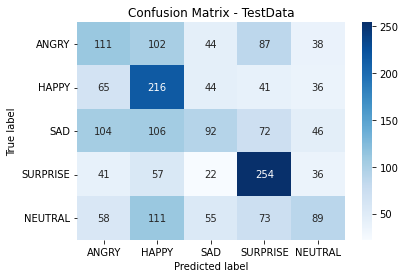

In [66]:
y_pred_mlp = mlp_model.predict_classes(X_test)
y_true = np.argmax(y_test,axis=1)
plot_confusion_matrix(y_true, y_pred_mlp)

##Neural Network Model Evaluation on distance inputs

We saw yesterday that building a model on the distances between facial landmarks did better than on raw pixel inputs, is this true for these models as well? 

In [67]:
#Load the data (Distances between facial Landmarks)
dataX_lm = np.load('./dataX.npy')
#dataY_lm = np.load('./dataY.npy')

# convert labels to one hot encoding
#y_onehot = keras.utils.to_categorical(dataY_lm, len(set(dataY_lm)))

# split Data into Train, Test (90-10)
X_train_lm, X_test_lm, y_train_lm, y_test_lm = train_test_split(dataX_lm, y_onehot, test_size=0.1, random_state=42)

#### Standardize the data ##########
lm_scaler = StandardScaler()
lm_scaler.fit(X_train_lm)
X_train_lm = lm_scaler.transform(X_train_lm)
X_test_lm = lm_scaler.transform(X_test_lm)

In [68]:
lm_model = Sequential()
lm_model.add(Dense(5120, activation='relu',kernel_initializer='glorot_normal', input_shape=( X_train_lm.shape[1]   ,)))
lm_model.add(Dropout(0.2))
lm_model.add(Dense(512,kernel_initializer='glorot_normal', activation='relu'))
lm_model.add(Dropout(0.2))
lm_model.add(Dense(256,kernel_initializer='glorot_normal', activation='relu'))
lm_model.add(Dropout(0.2))
lm_model.add(Dense(n_labels, activation='softmax'))

In [69]:
# Compliling the model with SGD optimixer and categorical crossentropy loss
lm_model.compile(loss=categorical_crossentropy, optimizer=SGD(lr=0.001), metrics=['acc'])

#Saves the Best Model Based on Val Loss
checkpoint = ModelCheckpoint('best_lm_model.h5', verbose=1, monitor='val_loss',save_best_only=True,  mode='auto')  
#training the model
lm_history = lm_model.fit(X_train_lm, y_train_lm, batch_size=batch_size, epochs=epochs, 
                          verbose=1, callbacks=[checkpoint], validation_data=(X_test_lm, y_test_lm), shuffle=True)

Train on 18000 samples, validate on 2000 samples
Epoch 1/20
18000/18000 [==============================] - 2s 117us/step - loss: 1.4979 - acc: 0.3686 - val_loss: 1.3084 - val_acc: 0.4685

Epoch 00001: val_loss improved from inf to 1.30838, saving model to best_lm_model.h5
Epoch 2/20
18000/18000 [==============================] - 2s 113us/step - loss: 1.3615 - acc: 0.4339 - val_loss: 1.2684 - val_acc: 0.4755

Epoch 00002: val_loss improved from 1.30838 to 1.26840, saving model to best_lm_model.h5
Epoch 3/20
18000/18000 [==============================] - 2s 111us/step - loss: 1.3163 - acc: 0.4511 - val_loss: 1.2425 - val_acc: 0.4840

Epoch 00003: val_loss improved from 1.26840 to 1.24246, saving model to best_lm_model.h5
Epoch 4/20
18000/18000 [==============================] - 2s 111us/step - loss: 1.2922 - acc: 0.4634 - val_loss: 1.2307 - val_acc: 0.4910

Epoch 00004: val_loss improved from 1.24246 to 1.23071, saving model to best_lm_model.h5
Epoch 5/20
18000/18000 [===================

### Evaluate model

In [70]:
lm_performance = lm_model.evaluate(X_test_lm, y_test, batch_size=64)

2000/2000 [==============================] - 0s 59us/step


###Visualize accuracy and loss over training + display best model's performance

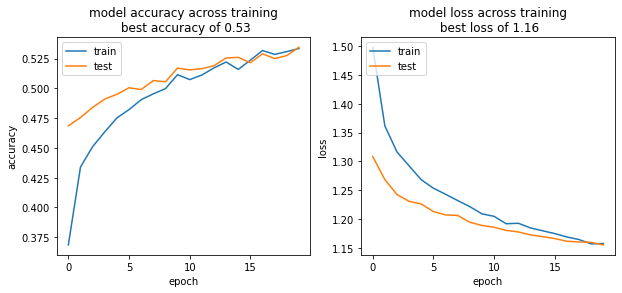

In [71]:
plot_graphs(lm_history, lm_performance)

#Convolutional Neural Networks for Emotion Detection!

###Model Hyperparameters

In [72]:
# we'll use the same epochs and batch size as above
width, height = int(np.sqrt(X_train.shape[1])), int(np.sqrt(X_train.shape[1]))

###Reshape the inputs

In [73]:
# pixels were vectors
print(X_train.shape) 

(18000, 2304)


In [74]:
X_train_cnn = X_train.reshape(len(X_train),height,width)
X_test_cnn = X_test.reshape(len(X_test),height,width)

# we've converted them to images
print(X_train_cnn.shape) 

(18000, 48, 48)


In [75]:
# now we add one more dimension for model compatability
X_train_cnn = np.expand_dims(X_train_cnn,3)
X_test_cnn = np.expand_dims(X_test_cnn,3)

print(X_train_cnn.shape)

(18000, 48, 48, 1)


In [76]:
# Change the hyperparameters in the model below 

# initialize model
cnn_model = Sequential()
# this conv layer has 64 filters! the input shape needs to be the same dimensions of the image
cnn_model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', input_shape=(width, height, 1)))
# batch normalization 
cnn_model.add(BatchNormalization())
# max pooling
cnn_model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
# dropout
cnn_model.add(Dropout(0.5))

# flatten all the outputs between convolutional and dense layers
cnn_model.add(Flatten())
# add a "dense layer" (i.e. the fully connected layers in MLPs) with dropout
cnn_model.add(Dense(512, activation='relu'))
# output layer
cnn_model.add(Dense(n_labels, activation='softmax'))

In [77]:
#

# pedigogically, it's probably a good idea to not use this model, but it's nice to have in case
# comparing the basic model above with transfer learning more clearly motivates that approach

cnn_model = Sequential()

cnn_model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', input_shape=(width, height, 1), kernel_regularizer=l2(0.01)))
cnn_model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'))
cnn_model.add(BatchNormalization())
cnn_model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
cnn_model.add(Dropout(0.5))

cnn_model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'))
cnn_model.add(BatchNormalization())
cnn_model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'))
cnn_model.add(BatchNormalization())
cnn_model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
cnn_model.add(Dropout(0.5))

cnn_model.add(Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same'))
cnn_model.add(BatchNormalization())
cnn_model.add(Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same'))
cnn_model.add(BatchNormalization())
cnn_model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
cnn_model.add(Dropout(0.5))

cnn_model.add(Conv2D(512, kernel_size=(3, 3), activation='relu', padding='same'))
cnn_model.add(BatchNormalization())
cnn_model.add(Conv2D(512, kernel_size=(3, 3), activation='relu', padding='same'))
cnn_model.add(BatchNormalization())
cnn_model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
cnn_model.add(Dropout(0.5))

cnn_model.add(Flatten())

cnn_model.add(Dense(512, activation='relu'))
cnn_model.add(Dropout(0.4))
cnn_model.add(Dense(256, activation='relu'))
cnn_model.add(Dropout(0.4))
cnn_model.add(Dense(128, activation='relu'))
cnn_model.add(Dropout(0.5))
cnn_model.add(Dense(n_labels, activation='softmax'))


In [78]:
#Saves the Best Model Based on Val Loss
checkpoint = ModelCheckpoint('best_cnn_model.h5', verbose=1, monitor='val_loss',save_best_only=True, mode='auto')  

# compliling the model with adam optimixer and categorical crossentropy loss
cnn_model.compile(loss=categorical_crossentropy, optimizer=Adam(lr=0.001, beta_1=0.9, beta_2=0.999), metrics=['acc'])

# training the model
cnn_history = cnn_model.fit(X_train_cnn, y_train, batch_size=batch_size, epochs=epochs, verbose=1, 
                            callbacks=[checkpoint], validation_data=(X_test_cnn, y_test), shuffle=True)

Train on 18000 samples, validate on 2000 samples
Epoch 1/20
18000/18000 [==============================] - 13s 742us/step - loss: 1.8075 - acc: 0.2259 - val_loss: 1.6239 - val_acc: 0.2425

Epoch 00001: val_loss improved from inf to 1.62392, saving model to best_cnn_model.h5
Epoch 2/20
18000/18000 [==============================] - 12s 658us/step - loss: 1.5969 - acc: 0.2652 - val_loss: 1.5736 - val_acc: 0.2715

Epoch 00002: val_loss improved from 1.62392 to 1.57358, saving model to best_cnn_model.h5
Epoch 3/20
18000/18000 [==============================] - 12s 658us/step - loss: 1.5157 - acc: 0.3116 - val_loss: 1.4858 - val_acc: 0.3365

Epoch 00003: val_loss improved from 1.57358 to 1.48583, saving model to best_cnn_model.h5
Epoch 4/20
18000/18000 [==============================] - 12s 657us/step - loss: 1.4487 - acc: 0.3405 - val_loss: 1.3973 - val_acc: 0.3570

Epoch 00004: val_loss improved from 1.48583 to 1.39729, saving model to best_cnn_model.h5
Epoch 5/20
18000/18000 [===========

###Evaluate the model

In [79]:
# YOUR CODE HERE
cnn_performance = cnn_model.evaluate(X_test_cnn, y_test, batch_size=64)

2000/2000 [==============================] - 0s 212us/step


###Plot Accuracy and Loss

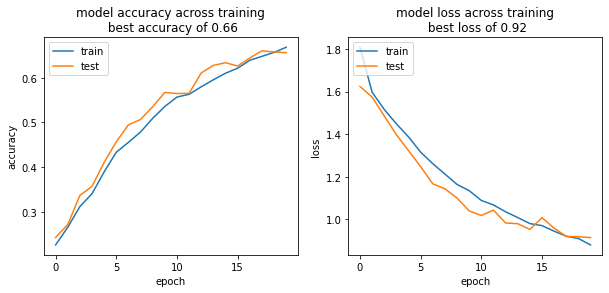

In [80]:
# YOUR CODE HERE 
plot_graphs(cnn_history, cnn_performance)

#Transfer Learning

In [82]:
#@title Run this to build your transfer learning model { display-mode: "form" }

import keras
from keras.models import Sequential
from keras.layers import Activation, MaxPooling2D, Dropout, Flatten, Reshape, Dense, Conv2D, GlobalAveragePooling2D
from keras.wrappers.scikit_learn import KerasClassifier
import keras.optimizers as optimizers
from keras.applications.vgg16 import VGG16

# load the vgg network that is an 'expert' at 'imagenet' but do not include the FC layers
vgg_expert = VGG16(weights = 'imagenet', include_top = False, input_shape = (48, 48, 3))

# we add the first 12 layers of vgg to our own model vgg_model
vgg_model = Sequential()
vgg_model.add(vgg_expert)

# and then add our own layers on top of it
vgg_model.add(GlobalAveragePooling2D())
vgg_model.add(Dense(1024, activation = 'relu'))
vgg_model.add(Dropout(0.3))
vgg_model.add(Dense(512, activation = 'relu'))
vgg_model.add(Dropout(0.3))
vgg_model.add(Dense(5, activation = 'sigmoid'))

# finally, we build the vgg model and turn it on so we can use it!
vgg_model.compile(loss = 'categorical_crossentropy', 
          optimizer = optimizers.SGD(lr=1e-4, momentum=0.95), 
          metrics=['acc'])

X_TRAIN = np.array([np.transpose(np.array([X_train_cnn[ix].squeeze() for i in range(3)]), (1,2,0)) for ix in range(len(X_train))])
X_TEST = np.array([np.transpose(np.array([X_test_cnn[ix].squeeze() for i in range(3)]), (1,2,0)) for ix in range(len(X_test))])

#training the model
vgg_history = vgg_model.fit(X_TRAIN, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          callbacks=[checkpoint],
          validation_data=(X_TEST, y_test),
          shuffle=True)

Train on 18000 samples, validate on 2000 samples
Epoch 1/20
18000/18000 [==============================] - 11s 628us/step - loss: 1.5517 - acc: 0.2971 - val_loss: 1.3797 - val_acc: 0.4330

Epoch 00001: val_loss did not improve from 0.91531
Epoch 2/20
18000/18000 [==============================] - 11s 608us/step - loss: 1.3408 - acc: 0.4261 - val_loss: 1.2245 - val_acc: 0.5095

Epoch 00002: val_loss did not improve from 0.91531
Epoch 3/20
18000/18000 [==============================] - 11s 610us/step - loss: 1.2106 - acc: 0.5046 - val_loss: 1.0934 - val_acc: 0.5630

Epoch 00003: val_loss did not improve from 0.91531
Epoch 4/20
18000/18000 [==============================] - 11s 608us/step - loss: 1.0955 - acc: 0.5576 - val_loss: 1.0264 - val_acc: 0.5830

Epoch 00004: val_loss did not improve from 0.91531
Epoch 5/20
18000/18000 [==============================] - 11s 611us/step - loss: 1.0302 - acc: 0.5847 - val_loss: 0.9910 - val_acc: 0.6045

Epoch 00005: val_loss did not improve from 0.91

###Evaluate model

In [83]:
vgg_performance = vgg_model.evaluate(X_TEST, y_test, batch_size=64)

2000/2000 [==============================] - 0s 217us/step


###Visualize accuracy and loss over training + display best model's performance

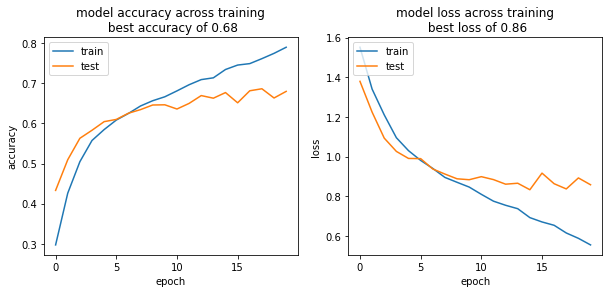

In [84]:
# YOUR CODE HERE
plot_graphs(vgg_history, vgg_performance)

# Determine some reference accuracy scores

In [85]:
from sklearn.neighbors import KNeighborsClassifier

# pixel-based knn classification accuracy... this will take a few minutes 
knn_pixel = KNeighborsClassifier(n_neighbors=3)
knn_pixel.fit(X_train, y_train)
knn_predictions_pixel = knn_pixel.predict(X_test)
knn_accuracy_pixel = np.mean(knn_predictions_pixel.argmax(1) == y_test.argmax(1))

# landmark-based knn classification accuracy... this will take a few minutes 
knn_lm = KNeighborsClassifier(n_neighbors=3)
knn_lm.fit(X_train_lm, y_train_lm)
knn_predictions_lm = knn_lm.predict(X_test_lm)
knn_accuracy_lm = np.mean( knn_predictions_lm.argmax(1) == y_test_lm.argmax(1))

# chance accuracy
chance_accuracy = 1/n_labels

# human accuracy
human_accuracy = .65 

In [86]:
def compare_learning(mlp, lm, cnn, vgg, benchmarks): 

  plt.figure(figsize=[7, 5])  

  # summarize history for accuracy

  plt.xticks(range(4, epochs+1,5), range(5, epochs+1,5) )
  
  plt.title('Performance of multiple models across training', y=1.05, fontsize=15)

  plt.ylim([.15, .72])

  plt.plot(lm.history['val_acc'], linestyle='-', color='purple', )
  plt.plot(mlp.history['val_acc'], linestyle='--', color='purple')

  plt.plot(vgg.history['val_acc'],color='blue', linestyle='-', linewidth=2)
  plt.plot(cnn.history['val_acc'],color='red', linestyle='-', linewidth=2)
  
  plt.ylabel('Accuracy', fontsize=15)
  plt.xlabel('Training Epoch', fontsize=15)


  plt.legend(['MLP''$_{landmarks}$', 'MLP''$_{pixels}$', 'CNN''$_{pretrained}$', 'CNN''$_{from.scratch}$'],
             framealpha=0, title_fontsize=9,loc=8)

  plt.xticks(range(4, epochs+1,5), range(5, epochs+1,5) )
  plt.ylim([.11, .72])

  for i_benchmark in benchmarks: 
    plt.scatter(x=epochs, y=references[i_benchmark], color='black', marker='_', s=200) 
    plt.annotate('%s: %d%%'%( i_benchmark, references[i_benchmark] *100), xy=(epochs+1, references[i_benchmark]-.005), size=10, color='black', ha='left') 
  plt.annotate('Important References', xy=(epochs+.5, .69), size=10, color='black', ha='left', fontweight='bold') 

  plt.ylim([.11, .72])
  plt.gca().spines['right'].set_color('none')
  plt.gca().spines['top'].set_color('none')

  plt.show()

In [87]:
references = {'$KNN_{pixel}$ Accuracy': knn_accuracy_pixel, '$KNN_{landmark}$ Accuracy': knn_accuracy_lm, 'Human Accuracy': human_accuracy, 'chance': chance_accuracy}

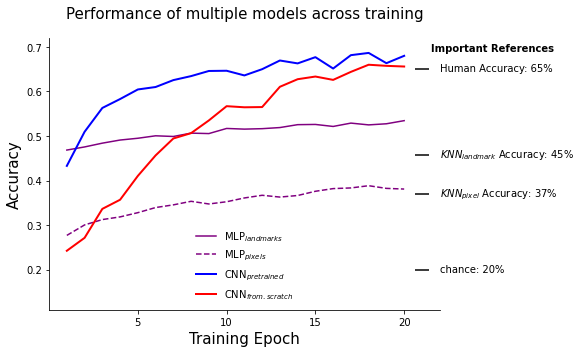

In [88]:
compare_learning(mlp_history, lm_history, cnn_history, vgg_history, references)

###How can we explain this pattern of performance across all these models?